真正的感知机
===
将Sigmoid激活函数与MSE损失加入感知机

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

# 1.导入数据

In [2]:
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 50

##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='/Users/JJZHK/data/input/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/Users/JJZHK/data/input/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


# 2.模型实现

In [3]:
class MultilayerPerceptron():

    def __init__(self, num_features, num_hidden, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        self.num_classes = num_classes
        
        # hidden 1
        self.weight_1 = torch.zeros(num_hidden, num_features, 
                                    dtype=torch.float).normal_(0.0, 0.1)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)
        
        # output
        self.weight_o = torch.zeros(self.num_classes, num_hidden, 
                                    dtype=torch.float).normal_(0.0, 0.1)
        self.bias_o = torch.zeros(self.num_classes, dtype=torch.float)
        
    def forward(self, x):
        # hidden 1
        
        # input dim: [n_hidden, n_features] dot [n_features, n_examples] .T
        # output dim: [n_examples, n_hidden]
        z_1 = torch.mm(x, self.weight_1.t()) + self.bias_1
        a_1 = torch.sigmoid(z_1)

        # hidden 2
        # input dim: [n_classes, n_hidden] dot [n_hidden, n_examples] .T
        # output dim: [n_examples, n_classes]
        z_2 = torch.mm(a_1, self.weight_o.t()) + self.bias_o
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2

    def backward(self, x, a_1, a_2, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = torch.FloatTensor(y.size(0), self.num_classes)
        y_onehot.zero_()
        y_onehot.scatter_(1, y.view(-1, 1).long(), 1)
        

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        dloss_da2 = 2.*(a_2 - y_onehot) / y.size(0)

        # input/output dim: [n_examples, n_classes]
        da2_dz2 = a_2 * (1. - a_2) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = dloss_da2 * da2_dz2 # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        dz2__dw_out = a_1
        
        # input dim: [n_classlabels, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classlabels, n_hidden]
        dloss__dw_out = torch.mm(delta_out.t(), dz2__dw_out)
        dloss__db_out = torch.sum(delta_out, dim=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        dz2__a1 = self.weight_o
        
        # output dim: [n_examples, n_hidden]
        dloss_a1 = torch.mm(delta_out, dz2__a1)
        
        # [n_examples, n_hidden]
        da1__dz1 = a_1 * (1. - a_1) # sigmoid derivative
        
        # [n_examples, n_features]
        dz1__dw1 = x
        
        # output dim: [n_hidden, n_features]
        dloss_dw1 = torch.mm((dloss_a1 * da1__dz1).t(), dz1__dw1)
        dloss_db1 = torch.sum((dloss_a1 * da1__dz1), dim=0)

        return dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1

# 3.训练

In [4]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot


def loss_func(targets_onehot, probas_onehot):
    return torch.mean(torch.mean((targets_onehot - probas_onehot)**2, dim=0))


def compute_mse(net, data_loader):
    curr_mse, num_examples = torch.zeros(model.num_classes).float(), 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            logits, probas = net.forward(features)
            y_onehot = to_onehot(targets, model.num_classes)
            loss = torch.sum((y_onehot - probas)**2, dim=0)
            num_examples += targets.size(0)
            curr_mse += loss

        curr_mse = torch.mean(curr_mse/num_examples, dim=0)
        return curr_mse


def train(model, data_loader, num_epochs,
          learning_rate=0.1):
    
    minibatch_cost = []
    epoch_cost = []
    
    for e in range(num_epochs):
        
        for batch_idx, (features, targets) in enumerate(train_loader):
            
            features = features.view(-1, 28*28)
            
            #### Compute outputs ####
            a_1, a_2 = model.forward(features)

            #### Compute gradients ####
            dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1 = \
                model.backward(features, a_1, a_2, targets)

            #### Update weights ####
            model.weight_1 -= learning_rate * dloss_dw1
            model.bias_1 -= learning_rate * dloss_db1
            model.weight_o -= learning_rate * dloss__dw_out
            model.bias_o -= learning_rate * dloss__db_out
            
            #### Logging ####
            curr_cost = loss_func(to_onehot(targets, model.num_classes), a_2)
            minibatch_cost.append(curr_cost)
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(e+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), curr_cost))
        
        #### Logging ####        
        curr_cost = compute_mse(model, train_loader)
        epoch_cost.append(curr_cost)
        print('Epoch: %03d/%03d |' % (e+1, NUM_EPOCHS), end="")
        print(' Train MSE: %.5f' % curr_cost)

    return minibatch_cost, epoch_cost

In [5]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden=50,
                             num_classes=10)

minibatch_cost, epoch_cost = train(model, 
                                   train_loader,
                                   num_epochs=NUM_EPOCHS,
                                   learning_rate=0.1)

0.01447
Epoch: 017/050 | Batch 000/600 | Cost: 0.0128
Epoch: 017/050 | Batch 050/600 | Cost: 0.0160
Epoch: 017/050 | Batch 100/600 | Cost: 0.0183
Epoch: 017/050 | Batch 150/600 | Cost: 0.0136
Epoch: 017/050 | Batch 200/600 | Cost: 0.0144
Epoch: 017/050 | Batch 250/600 | Cost: 0.0109
Epoch: 017/050 | Batch 300/600 | Cost: 0.0104
Epoch: 017/050 | Batch 350/600 | Cost: 0.0146
Epoch: 017/050 | Batch 400/600 | Cost: 0.0099
Epoch: 017/050 | Batch 450/600 | Cost: 0.0096
Epoch: 017/050 | Batch 500/600 | Cost: 0.0145
Epoch: 017/050 | Batch 550/600 | Cost: 0.0160
Epoch: 017/050 | Train MSE: 0.01415
Epoch: 018/050 | Batch 000/600 | Cost: 0.0140
Epoch: 018/050 | Batch 050/600 | Cost: 0.0145
Epoch: 018/050 | Batch 100/600 | Cost: 0.0167
Epoch: 018/050 | Batch 150/600 | Cost: 0.0136
Epoch: 018/050 | Batch 200/600 | Cost: 0.0102
Epoch: 018/050 | Batch 250/600 | Cost: 0.0164
Epoch: 018/050 | Batch 300/600 | Cost: 0.0094
Epoch: 018/050 | Batch 350/600 | Cost: 0.0169
Epoch: 018/050 | Batch 400/600 | Cos

# 4.评估

Text(0.5, 0, 'Epoch')

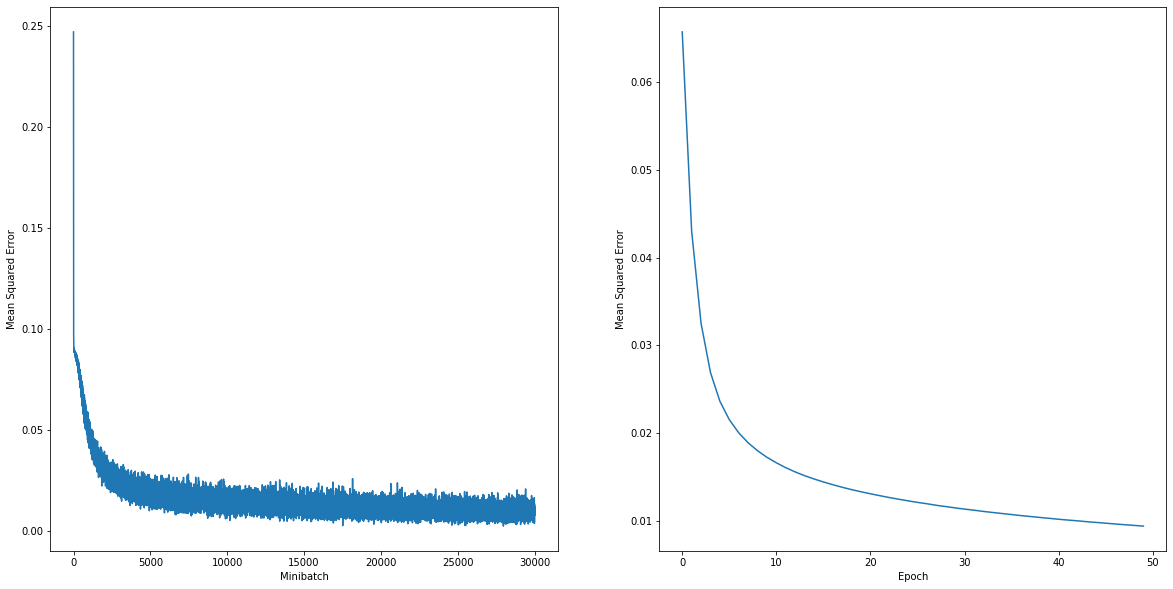

In [8]:
plt.figure(figsize=(20, 10), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Minibatch')

plt.subplot(1, 2, 2)
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')

In [9]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            _, outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 94.72
Test Accuracy: 94.49


# 5.预测

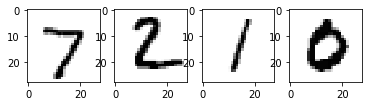

In [11]:
import matplotlib
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

In [12]:
_, predictions = model.forward(features[:4].view(-1, 28*28))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0])
